In [53]:
import numpy as np 
import jax.numpy as jnp
import jax
from jax import grad,jit,vmap
import jaxconv 
from jaxconv import *
from mlxtend.data import loadlocal_mnist
import platform
import utils
from utils import to_categorical
from utils import load_mnist
import matplotlib.pyplot as py
import timeit

Load Data

In [5]:
(train_data,train_labels),(test_data,test_labels)=load_mnist('../Sampling Network/data/')
train_data=train_data.reshape(60000,1,28,28)/255.0 
test_data=test_data.reshape(10000,1,28,28)/255.0 
train_labels=to_categorical(train_labels)
test_labels=to_categorical(test_labels)

speeding up layers

In [6]:
jit_conv=jit(conv)

Model

In [8]:
def forward(params,input):
  #2 Convolution Layers.
  layer1=jit_conv(input,params[0],im2col_matrix_layer1)
  layer1=jax.nn.relu(layer1)
  sampler=layer1
 
  ###FC network starts
  layer1=layer1.flatten()
  l1=np.dot(layer1,params[2][0].T)+params[2][1]
  l1=jax.nn.relu(l1)
  l2=np.dot(l1,params[3][0].T)+params[3][1] 
  l2=jax.nn.softmax(l2)
  return [l2,sampler]

def NLL(x,y): 
    return -np.log(x[np.argmax(y)]) #assuming one hot
def NLL_loss(params,i,t): 
  pred,_=jit(forward)(params,i)
  final=jit(NLL)(pred,t)
  return final

#Function to update parameters after gradient is calculated. 
#assumes the gradient input has shape [batch_size,weight matrix]
#Mini-batch SGD --> summed gradients. 
def update_weights(params, gradient ,lr=1.0): 
  for i in range(len(params)): #iterate through the layer. 
    params[i][0]=params[i][0]-(lr*np.sum(gradient[i][0],axis=0))
    params[i][1]=params[i][1]-(lr*np.sum(gradient[i][1],axis=0))
  return params


vmap_forward=vmap(forward,in_axes=(None,0)) #jax.vmap is used to vectorize the process to allow for batching. 
gradient_=jit(grad(NLL_loss,argnums=(0)))
vmap_gradient = vmap(gradient_,in_axes=(None,0,0))
gradient =jit(vmap_gradient)


In [57]:
onp.random.seed(1100)
conv_params =init_conv_parameters(filters=[2,2],size=[3,3],image_depth=1)
fc_params=init_parameters([300,10],input_shape=1568)
params=conv_params+fc_params #totalling 2 convs layers, 2 fc layers 
im2col_matrix_layer1=im2col(row=28,height=28,depth=1,padding=1) #This is the initial size so mnist starts at 1, but with 4 filters the next layer will be 4. 
im2col_matrix_layer2=im2col(row=14,height=14,depth=32,padding=1)
#im2col_matrix_layer3=im2col(row=7,height=7,depth=32,padding=1)


Main Training Loop

In [58]:
ctr=0

for i in range(10): #epochs
  start_time = timeit.default_timer()
  for j in range(400): #number of batches to iterate.
    
    dparams=gradient(params,train_data[ctr:ctr+100],train_labels[ctr:ctr+100]) #The last value is batch size
    params= jit(update_weights)(params,dparams,lr=0.001)
    ctr=ctr+100

    if ctr+100>40000:
      ctr=0
  elapsed = timeit.default_timer() - start_time
  print (f'epoch time: ' ,elapsed)  
  pred,_=jit(vmap_forward)(params,train_data[40300:40400])
  pred=np.argmax(pred,axis=1)

  targets=np.argmax(train_labels[40300:40400],axis=1)
  print (f'epoch: ', i+1)
  print(len(np.where(pred == targets)[0])/100)

epoch time:  2.367202998999346
epoch:  1
0.94
epoch time:  2.367669391000163
epoch:  2
0.97
epoch time:  2.469605603000673
epoch:  3
0.97
epoch time:  2.3734546999994564
epoch:  4
0.98
epoch time:  2.347651224999936
epoch:  5
0.98
epoch time:  2.3315938780006036
epoch:  6
0.98
epoch time:  2.3297171009999147
epoch:  7
0.97
epoch time:  2.371845891000703
epoch:  8
0.98
epoch time:  2.3289824299999964
epoch:  9
0.97
epoch time:  2.330150378000326
epoch:  10
0.97


In [31]:
conv_image=jit_conv(train_data[10],params[0],im2col_matrix_layer1)

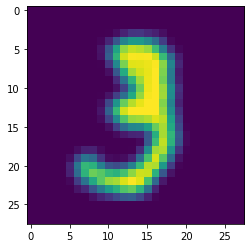

In [52]:
py.imshow(conv_image[6].reshape(28,28))

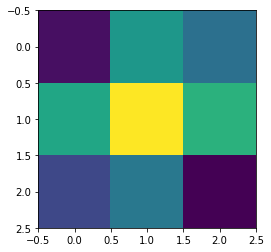

In [51]:
py.imshow(params[0][0][2][0])